In [ ]:
import pandas as pd

In [ ]:



df = pd.read_csv('masked_kiva_loans.csv')




# Data Cleaning


In [ ]:

import pandas as pd
# Drop columns with high number of unique values
df = df.drop(['borrower_genders'], axis=1)

# Fill missing values in 'sector' with 'Unknown'
df['sector'].fillna('Unknown', inplace=True)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Check for duplicate rows
df.duplicated().sum()

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Check for missing values
df.isnull().sum()

# Remove outliers in funded amount
Q1 = df['funded_amount'].quantile(0.25)
Q3 = df['funded_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['funded_amount'] >= lower_bound) & (df['funded_amount'] <= upper_bound)]

# Remove outliers in loan amount
Q1 = df['loan_amount'].quantile(0.25)
Q3 = df['loan_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['loan_amount'] >= lower_bound) & (df['loan_amount'] <= upper_bound)]

# Remove outliers in lender count
Q1 = df['lender_count'].quantile(0.25)
Q3 = df['lender_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['lender_count'] >= lower_bound) & (df['lender_count'] <= upper_bound)]

#  Evaluate a machine learning mode

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split  # Add this import statement


In [ ]:
# Define a function to evaluate and print metrics for regression models
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2) score:", r2)
    return mse, r2

In [ ]:
# Define a function to evaluate and print metrics for classification models
def evaluate_classification_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [ ]:
# Split the data into training and testing sets
X = df[['loan_amount', 'lender_count']]
y = df['funded_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train and evaluate multiple regression models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}


In [ ]:






for name, model in models.items():
    print("\n", name)
    model.fit(X_train, y_train)
    mse, r2 = evaluate_regression_model(model, X_test, y_test)

# Train and evaluate a classification model (Ridge Classifier)
X_class = df[['loan_amount', 'lender_count', 'term_in_months']]
y_class = np.where(df['funded_amount'] > df['funded_amount'].median(), 1, 0)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

classifier = RidgeClassifier()
classifier.fit(X_train_class, y_train_class)
evaluate_classification_model(classifier, X_test_class, y_test_class)



 Linear Regression
Mean Squared Error (MSE): 11114.192301172681
R-squared (R2) score: 0.8809864241931797

 Decision Tree Regressor
Mean Squared Error (MSE): 11831.402543514461
R-squared (R2) score: 0.8733063559315063

 Random Forest Regressor
Mean Squared Error (MSE): 10231.12466514113
R-squared (R2) score: 0.8904425352802896
Confusion Matrix:
 [[2419   69]
 [ 425 1573]]
Accuracy: 0.8898796255015604


In [ ]:

df.to_csv('cleaned_kiva_loans.csv', index=False)


#Time Sereis

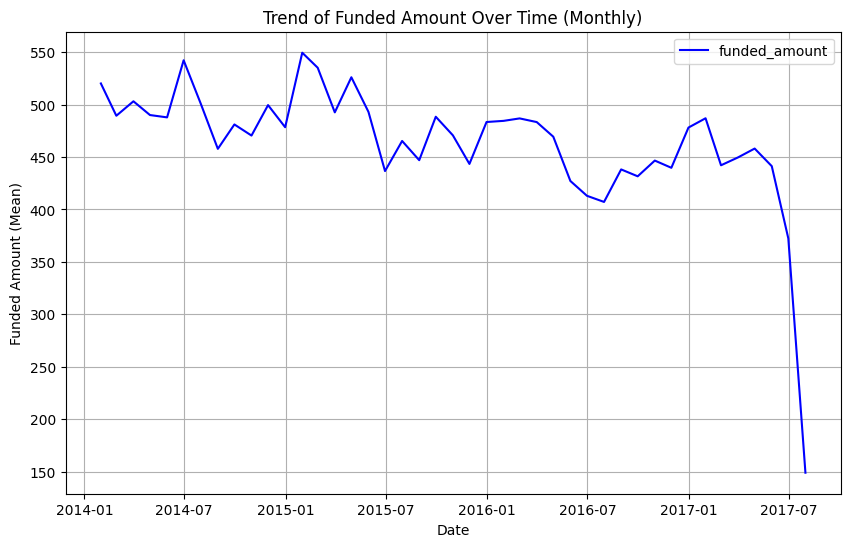

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
# Step 1: Visualize the time series

# Create a new DataFrame with only 'funded_amount' and 'date' columns
dfs = df[['funded_amount', 'date']].copy()

# Convert the 'date' column to datetime using .loc to modify the original DataFrame
df.loc[:, 'date'] = pd.to_datetime(df['date'])

# Display the first few rows of the new DataFrame
dfs.set_index('date', inplace=True)

dfs.head()


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Downsampling the data by resampling and aggregating over specific time intervals
interval = '1M'  # Resample data over monthly intervals
df_resampled = dfs.resample(interval).mean()  # Calculate the mean funded amount for each month

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the trend of funded amount over time (resampled and aggregated)
plt.plot(df_resampled.index, df_resampled['funded_amount'], label='funded_amount', color='blue')

# Add labels and title
plt.title('Trend of Funded Amount Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Funded Amount (Mean)')
plt.legend(loc='best')
plt.grid(True)
plt.show()



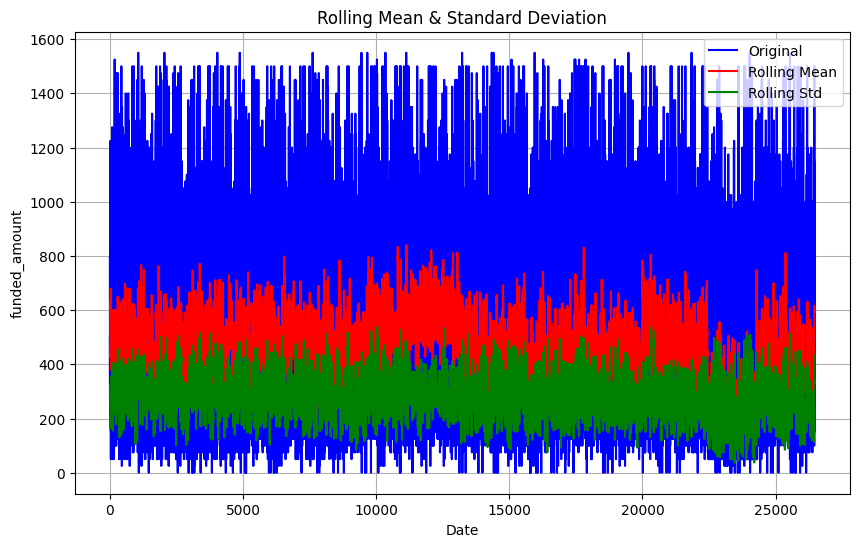

ADF Statistic: -12.204171819614556
p-value: 1.204135695774039e-22
Critical Values:
	1%: -3.4306422013285776
	5%: -2.8616691434746584
	10%: -2.5668387394112515


In [ ]:
def stationarize_series(series):
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Original', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('funded_amount')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

stationarize_series(df['funded_amount'])


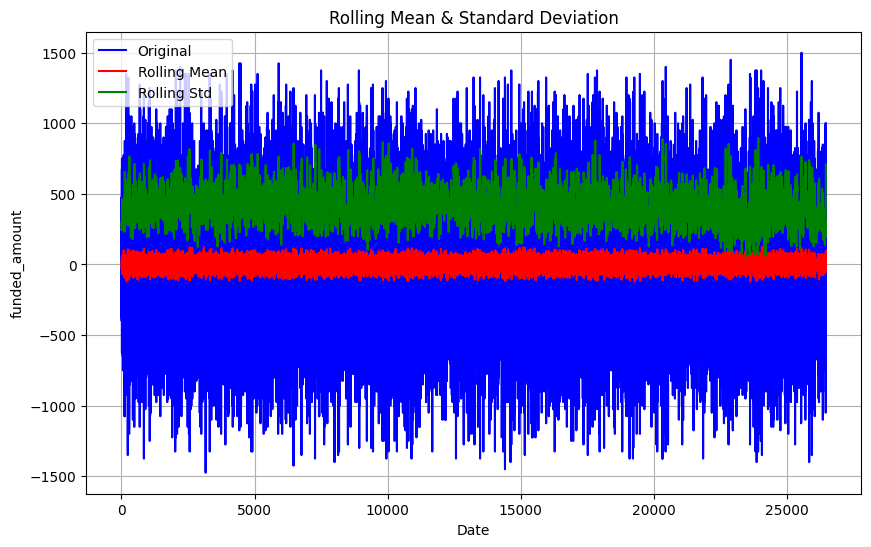

ADF Statistic: -36.61338016218194
p-value: 0.0
Critical Values:
	1%: -3.4306422143858515
	5%: -2.861669149245264
	10%: -2.566838742482831


In [ ]:
 stationarize_series(df.funded_amount.diff().dropna())

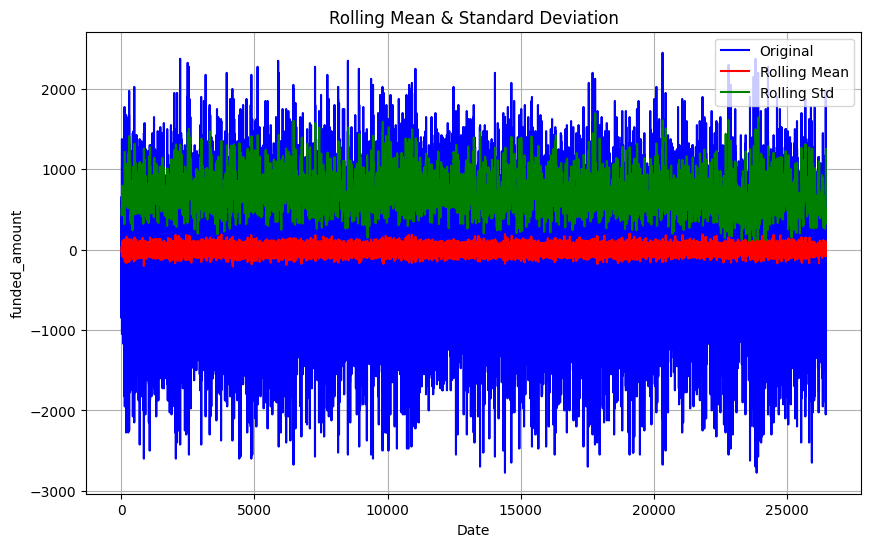

ADF Statistic: -48.4071361008794
p-value: 0.0
Critical Values:
	1%: -3.4306422274442925
	5%: -2.861669155016386
	10%: -2.5668387455546853


In [ ]:

 stationarize_series(df.funded_amount.diff().diff().dropna())

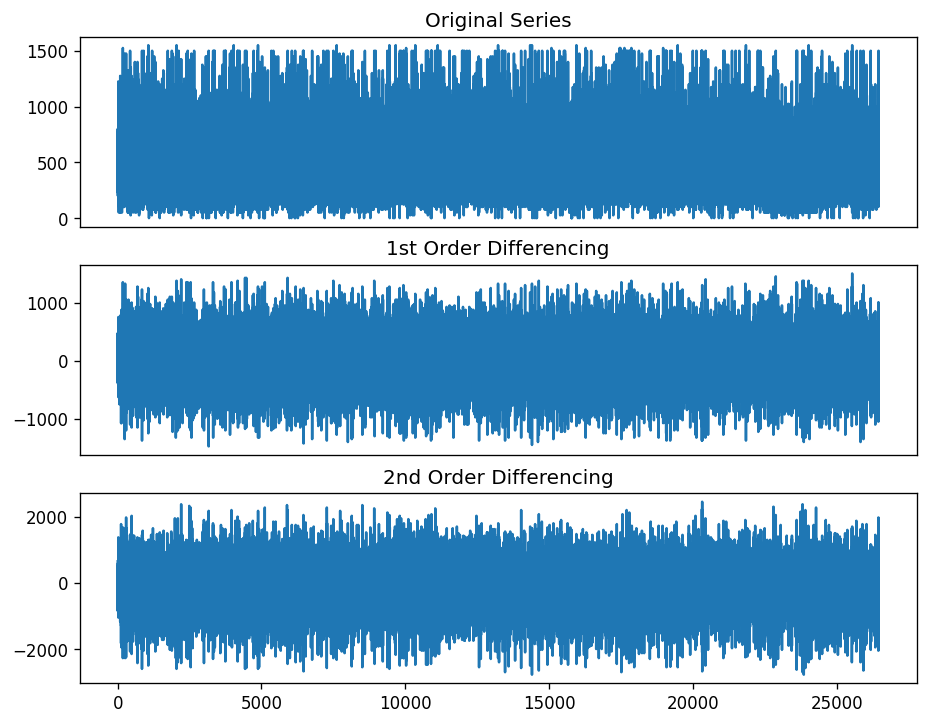

In [ ]:

 # Finding the value of the d parameter
 plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

 # Original Series
 fig, (ax1, ax2, ax3) = plt.subplots(3)
 ax1.plot(df.funded_amount); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
 # 1st Differencing
 ax2.plot(df.funded_amount.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
 # 2nd Differencing
 ax3.plot(df.funded_amount.diff().diff()); ax3.set_title('2nd Order Differencing')
 plt.show()

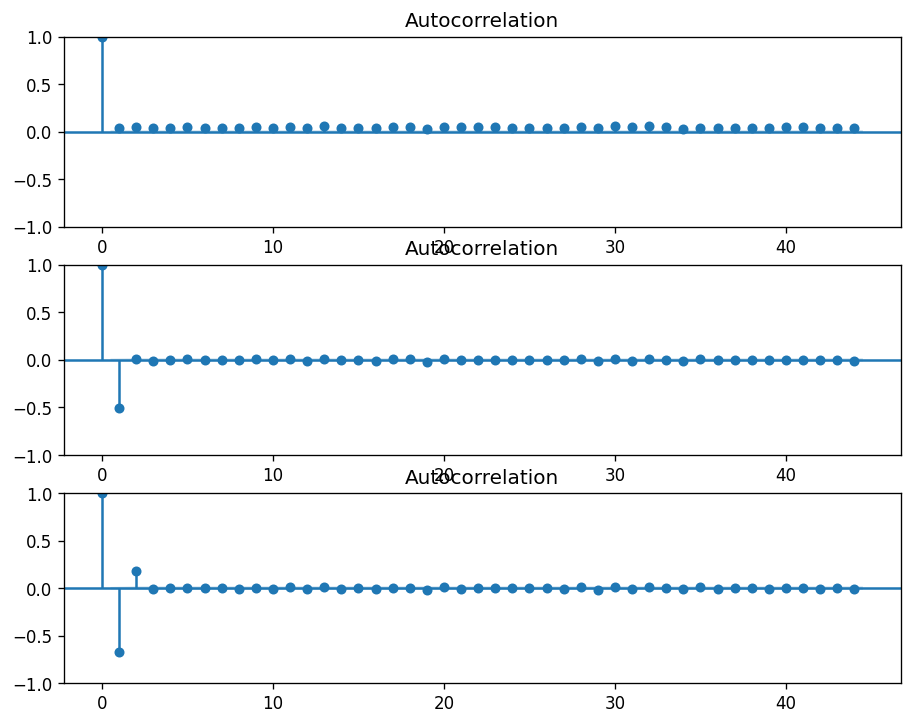

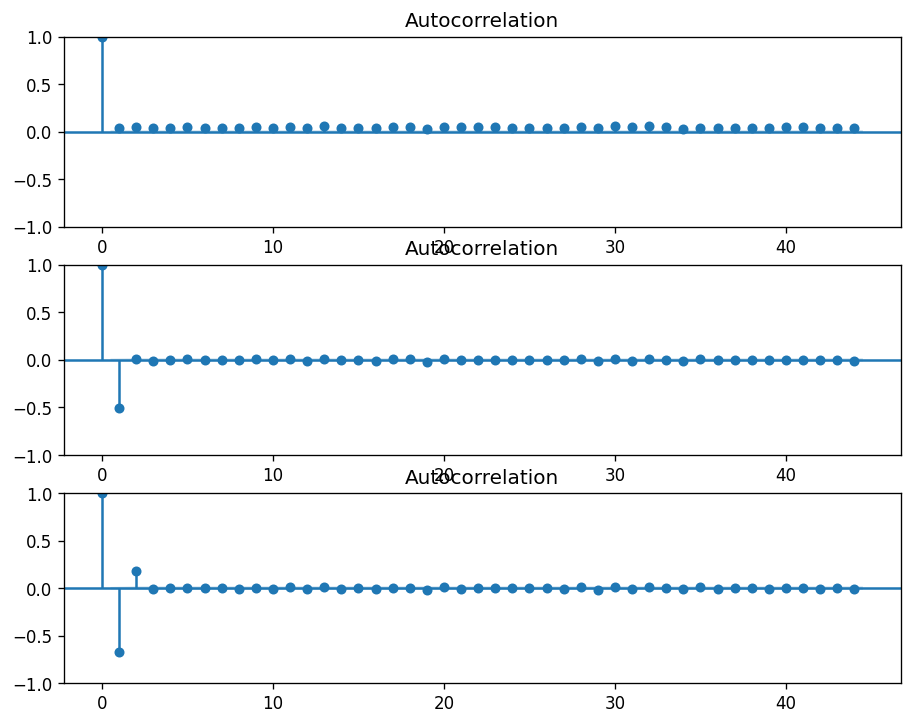

In [ ]:
 # Step 3: plot ACF & PACF
 from statsmodels.graphics.tsaplots import plot_acf
 fig, (ax1, ax2, ax3) = plt.subplots(3)
 plot_acf(df.funded_amount, ax=ax1)
 plot_acf(df.funded_amount.diff().dropna(), ax=ax2)
 plot_acf(df.funded_amount.diff().diff().dropna(), ax=ax3)

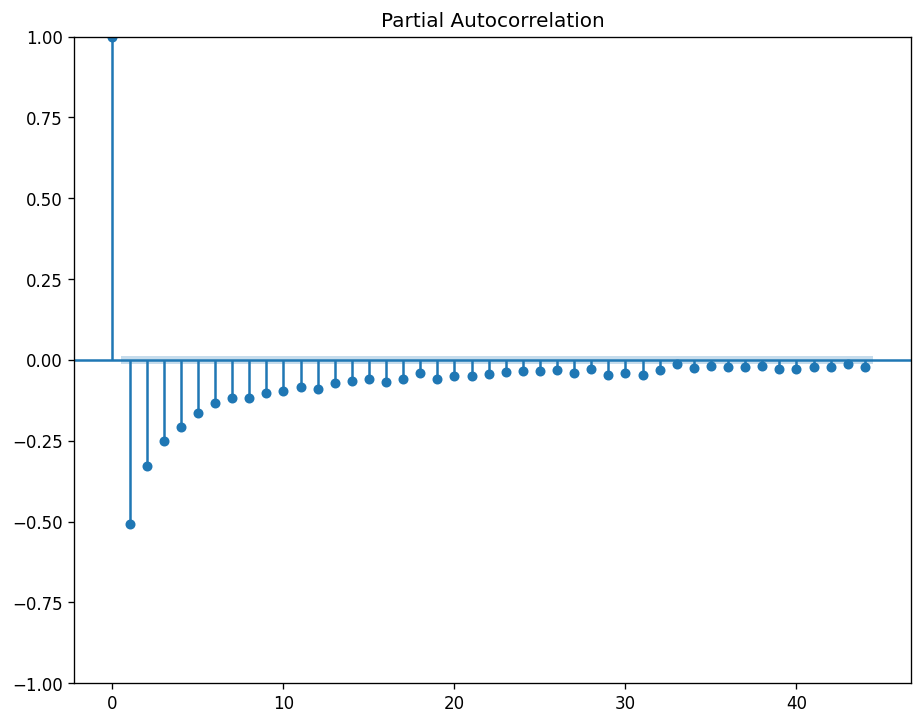

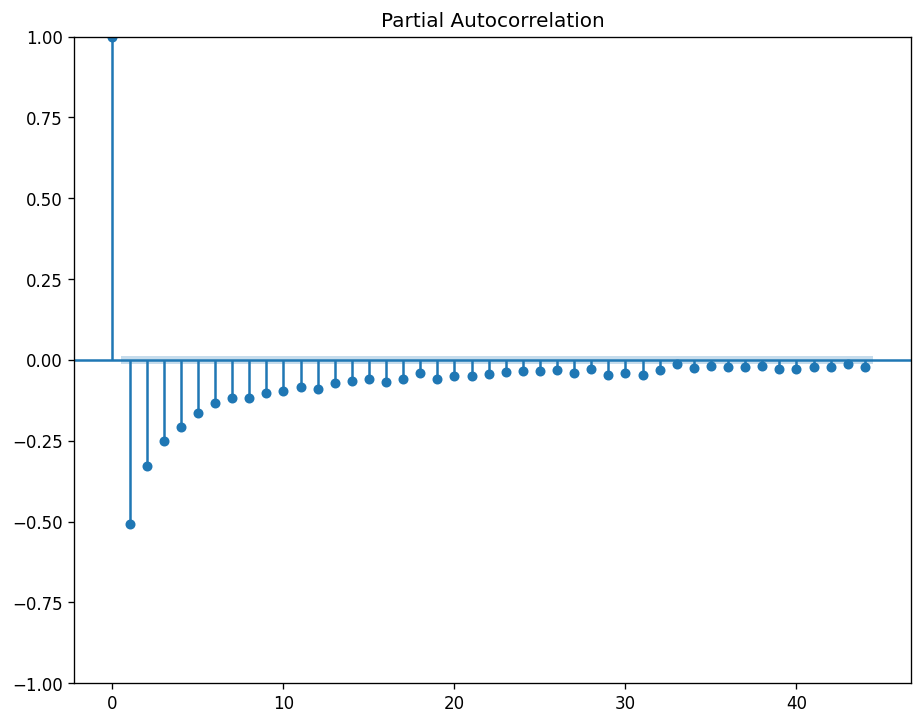

In [ ]:
 from statsmodels.graphics.tsaplots import plot_pacf
 plot_pacf(df.funded_amount.diff().dropna())

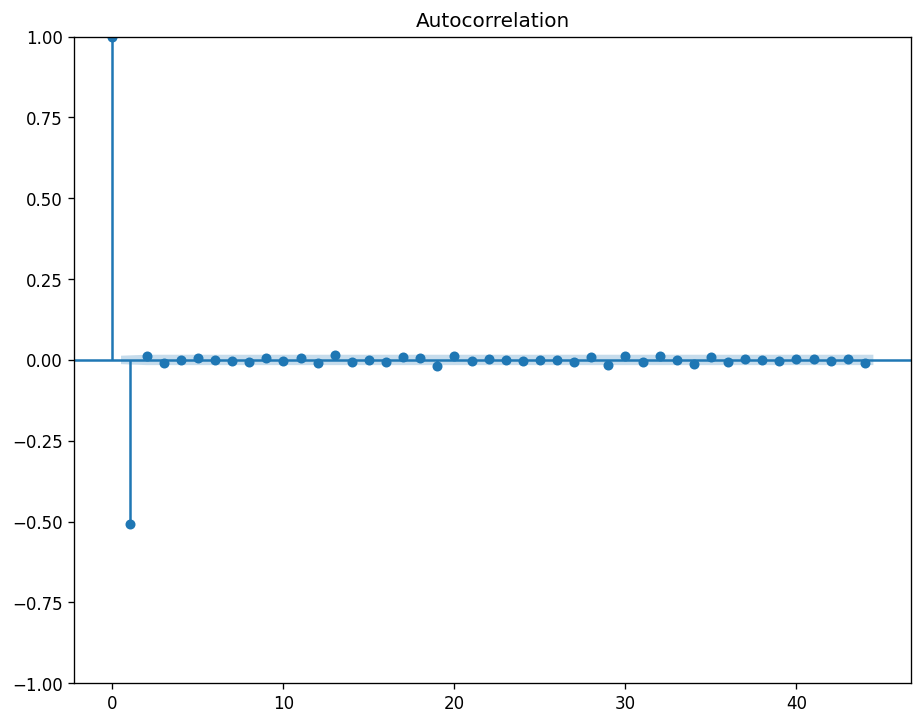

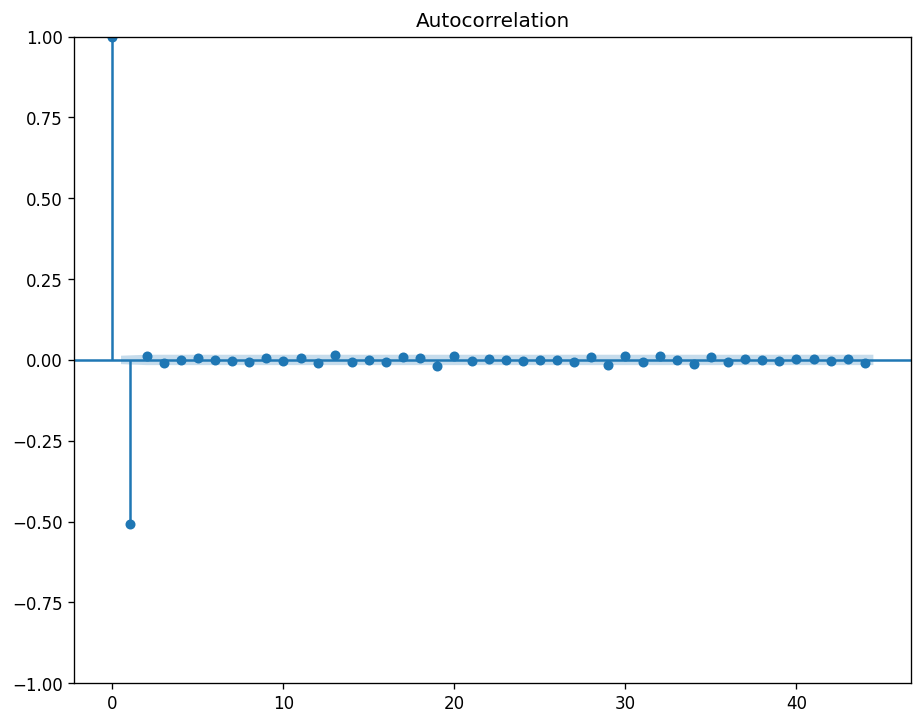

In [ ]:
 # Finding the value of the q parameter
 plot_acf(df.funded_amount.diff().dropna())

In [ ]:

# Step 4: Build the ARIMA model
# Based on the ACF and PACF plots, we can try ARIMA(1,1,1) or ARIMA(1,1,2)
model = ARIMA(df['funded_amount'], order=(1,1,1))
arima_model = model.fit()
#arima_model.summary()

# Step 5: Predict
forecast = arima_model.predict()
#forecast = arima_model.forecast()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


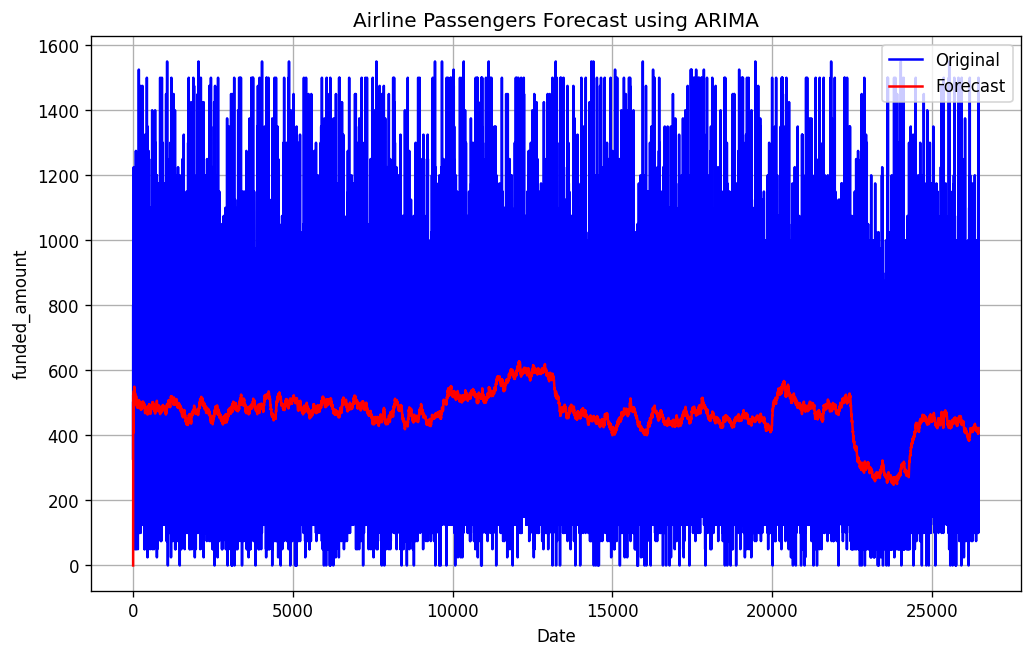

In [ ]:

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['funded_amount'], label='Original', color='blue')
plt.plot(df.index ,  forecast, label='Forecast', color='red')
plt.title('Airline Passengers Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('funded_amount')
plt.legend(loc='best')
plt.grid(True)
plt.show()